# PCB DCIR analysis

This example shows how to use PyAEDT to create a design in
Q3D Extractor and run a DC IR drop simulation starting from an EDB project.

Keywords: **Q3D**, **layout**, **DCIR**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core
import pyedb

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
# ## Set up project files and path
#
# Download needed project file and set up temporary project directory.

In [5]:
aedb_project = ansys.aedt.core.downloads.download_file(
    "edb/ANSYS-HSD_V1.aedb", destination=temp_folder.name
)
coil = ansys.aedt.core.downloads.download_file(
    source="inductance_3d_component",
    name="air_coil.a3dcomp",
    destination=temp_folder.name,
)
res = ansys.aedt.core.downloads.download_file(
    source="resistors", name="Res_0402.a3dcomp", destination=temp_folder.name
)
project_name = "HSD"
output_edb = os.path.join(temp_folder.name, project_name + ".aedb")
output_q3d = os.path.join(temp_folder.name, project_name + "_q3d.aedt")

## Open EDB project

Open the EDB project and create a cutout on the selected nets
before exporting to Q3D.

In [6]:
edb = pyedb.Edb(aedb_project, edbversion=AEDT_VERSION)
signal_nets = ["1.2V_AVDLL_PLL", "1.2V_AVDDL", "1.2V_DVDDL", "NetR106_1"]
ground_nets = ["GND"]
cutout_points = edb.cutout(
    signal_list=signal_nets,
    reference_list=ground_nets,
    output_aedb_path=output_edb,
)

PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.31.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database ANSYS-HSD_V1.aedb Opened in 2024.2


PyAEDT INFO: Cell main Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


PyAEDT INFO: EDB file save time: 0.00ms


PyAEDT INFO: Cutout Multithread started.


PyAEDT INFO: Net clean up Elapsed time: 0m 2sec


PyAEDT INFO: Extent Creation Elapsed time: 0m 0sec


PyAEDT INFO: 1988 Padstack Instances deleted. Elapsed time: 0m 1sec


PyAEDT INFO: 441 Primitives deleted. Elapsed time: 0m 2sec


PyAEDT INFO: 972 components deleted


PyAEDT INFO: EDB file save time: 0.00ms


PyAEDT INFO: Cutout completed. Elapsed time: 0m 6sec


## Identify pin positions

Identify [x,y] pin locations on the components to define where to assign sources
and sinks for Q3D.

In [7]:
pin_u11_scl = [
    i for i in edb.components["U11"].pins.values() if i.net_name == "1.2V_AVDLL_PLL"
]
pin_u9_1 = [i for i in edb.components["U9"].pins.values() if i.net_name == "1.2V_AVDDL"]
pin_u9_2 = [i for i in edb.components["U9"].pins.values() if i.net_name == "1.2V_DVDDL"]
pin_u11_r106 = [
    i for i in edb.components["U11"].pins.values() if i.net_name == "NetR106_1"
]

## Append Z Positions

Compute the Q3D 3D position. The units in EDB are meters so the
factor 1000 converts from meters to millimeters.

In [8]:
location_u11_scl = [i * 1000 for i in pin_u11_scl[0].position]
location_u11_scl.append(edb.components["U11"].upper_elevation * 1000)

location_u9_1_scl = [i * 1000 for i in pin_u9_1[0].position]
location_u9_1_scl.append(edb.components["U9"].upper_elevation * 1000)

location_u9_2_scl = [i * 1000 for i in pin_u9_2[0].position]
location_u9_2_scl.append(edb.components["U9"].upper_elevation * 1000)

location_u11_r106 = [i * 1000 for i in pin_u11_r106[0].position]
location_u11_r106.append(edb.components["U11"].upper_elevation * 1000)

## Identify pin positions for 3D components

Identify the pin positions where 3D components of passives are to be added.

In [9]:
location_l2_1 = [i * 1000 for i in edb.components["L2"].pins["1"].position]
location_l2_1.append(edb.components["L2"].upper_elevation * 1000)
location_l4_1 = [i * 1000 for i in edb.components["L4"].pins["1"].position]
location_l4_1.append(edb.components["L4"].upper_elevation * 1000)

location_r106_1 = [i * 1000 for i in edb.components["R106"].pins["1"].position]
location_r106_1.append(edb.components["R106"].upper_elevation * 1000)

## Save and close EDB

Save and close EDB. Then, open EDT in HFSS 3D Layout to generate the 3D model.

In [10]:
edb.save_edb()
edb.close_edb()
time.sleep(3)

h3d = ansys.aedt.core.Hfss3dLayout(
    output_edb, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyAEDT INFO: EDB file save time: 0.00ms


PyAEDT INFO: EDB file release time: 0.00ms


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_85e16aae-2f9e-492b-a7df-25a02d44c953.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 59755


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 1420.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmpirmnsxw9.ansys\HSD.aedb has been imported to project HSD


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


## Export to Q3D

Create a dummy setup and export the layout to Q3D.
The ``keep_net_name`` parameter reassigns Q3D net names from HFSS 3D Layout.

In [11]:
setup = h3d.create_setup()
setup.export_to_q3d(output_q3d, keep_net_name=True)
h3d.close_project()
time.sleep(3)

PyAEDT INFO: Project: HSD, Design: main, [info]  Translation Info: Export complete (00:00:04). (04:36:26 AM  Oct 31, 2024)


PyAEDT INFO: Project: HSD, Design: main, [info]  File written to C:/Users/ansys/AppData/Local/Temp/tmpirmnsxw9.ansys/HSD_q3d.aedt. (04:36:26 AM  Oct 31, 2024)


PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: EDB loaded.


PyAEDT INFO: Layers loaded.


PyAEDT INFO: Primitives loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.31.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database HSD.aedb Opened in 2024.2


PyAEDT INFO: Cell main Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


PyAEDT INFO: Processing net NetR106_1...


PyAEDT INFO: Processing net GND...


PyAEDT INFO: Processing net 1.2V_DVDDL...


PyAEDT INFO: Processing net 1.2V_AVDLL_PLL...


PyAEDT INFO: Processing net 1.2V_AVDDL...


PyAEDT INFO: Net processing completed.


PyAEDT INFO: Processing vias...


PyAEDT INFO: Vias processing completed.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpirmnsxw9.ansys\HSD_q3d.aedt.


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 1420!


PyAEDT INFO: Project HSD_q3d has been opened.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpirmnsxw9.ansys\HSD_q3d.aedt correctly loaded. Elapsed time: 0m 2sec


PyAEDT INFO: Active Design set to Q3DDesign1


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Renaming primitives for net NetR106_1...


PyAEDT INFO: Renaming primitives for net GND...


PyAEDT INFO: Union of 51 objects has been executed.


PyAEDT INFO: Renaming primitives for net 1_2V_DVDDL...


PyAEDT INFO: Union of 12 objects has been executed.


PyAEDT INFO: Renaming primitives for net 1_2V_AVDLL_PLL...


PyAEDT INFO: Union of 5 objects has been executed.


PyAEDT INFO: Renaming primitives for net 1_2V_AVDDL...


PyAEDT INFO: Union of 5 objects has been executed.


PyAEDT INFO: 1 Nets have been identified: GND_1


PyAEDT INFO: Closing the AEDT Project HSD_q3d


PyAEDT INFO: Project HSD_q3d closed correctly


PyAEDT INFO: EDB file release time: 0.00ms


PyAEDT INFO: Closing the AEDT Project HSD


PyAEDT INFO: Project HSD closed correctly


## Open Q3D

Launch the newly created Q3D project.

In [12]:
q3d = ansys.aedt.core.Q3d(output_q3d, version=AEDT_VERSION)
q3d.modeler.delete("GND")
q3d.modeler.delete("16_Bottom_L6")
q3d.delete_all_nets()

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpirmnsxw9.ansys\HSD_q3d.aedt.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Returning found Desktop session with PID 1420!


PyAEDT INFO: Project HSD_q3d has been opened.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpirmnsxw9.ansys\HSD_q3d.aedt correctly loaded. Elapsed time: 0m 8sec


PyAEDT INFO: Active Design set to Q3DDesign1


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Deleted 1 Objects: GND.


PyAEDT INFO: Deleted 1 Objects: 16_Bottom_L6.


True

## Insert inductors

Create coordinate systems and place 3D component inductors.

In [13]:
q3d.modeler.create_coordinate_system(location_l2_1, name="L2")
comp = q3d.modeler.insert_3d_component(coil, coordinate_system="L2")
comp.rotate(q3d.AXIS.Z, -90)
comp.parameters["n_turns"] = "3"
comp.parameters["d_wire"] = "100um"
q3d.modeler.set_working_coordinate_system("Global")
q3d.modeler.create_coordinate_system(location_l4_1, name="L4")
comp2 = q3d.modeler.insert_3d_component(coil, coordinate_system="L4")
comp2.rotate(q3d.AXIS.Z, -90)
comp2.parameters["n_turns"] = "3"
comp2.parameters["d_wire"] = "100um"
q3d.modeler.set_working_coordinate_system("Global")

q3d.modeler.set_working_coordinate_system("Global")
q3d.modeler.create_coordinate_system(location_r106_1, name="R106")
comp3 = q3d.modeler.insert_3d_component(
    res, geometry_parameters={"$Resistance": 2000}, coordinate_system="R106"
)
comp3.rotate(q3d.AXIS.Z, -90)

q3d.modeler.set_working_coordinate_system("Global")

True

## Delete dielectrics

Delete all dielectric objects since they are not needed in DC analysis.

PyAEDT INFO: Deleted 4 Objects: DE1,DE3,DE5,DE7.


PyAEDT INFO: Deleted 6 Objects: DE2,DE6,Inner1_GND1_t_fill,Inner2_PWR1_t_fill,Inner5_PWR2_t_fill,Inner6_GND2_t_fill.


PyAEDT INFO: Deleted 3 Objects: Inner3_Sig1_t_fill,Inner4_Sig2_t_fill,Megtron4_1mm.


PyAEDT INFO: Deleted 2 Objects: 16_Bottom_t_fill,1_Top_t_fill.


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


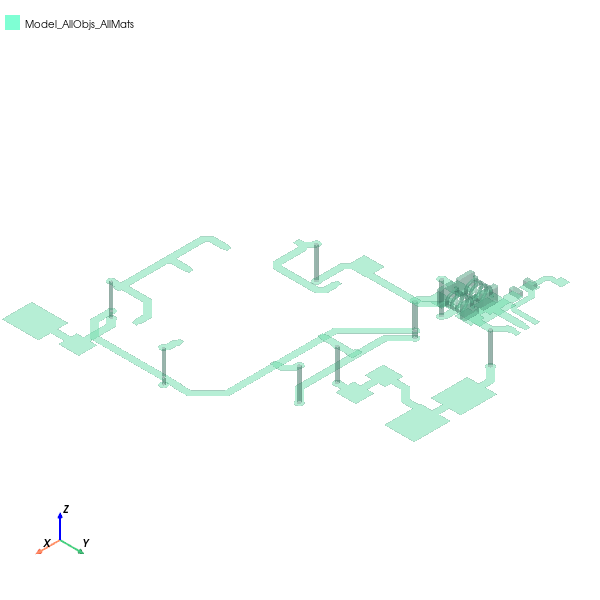

In [14]:
q3d.modeler.delete(q3d.modeler.get_objects_by_material("Megtron4"))
q3d.modeler.delete(q3d.modeler.get_objects_by_material("Megtron4_2"))
q3d.modeler.delete(q3d.modeler.get_objects_by_material("Megtron4_3"))
q3d.modeler.delete(q3d.modeler.get_objects_by_material("Solder Resist"))

objs_copper = q3d.modeler.get_objects_by_material("copper")
objs_copper_names = [i.name for i in objs_copper]
q3d.plot(
    show=False,
    assignment=objs_copper_names,
    plot_as_separate_objects=False,
    output_file=os.path.join(temp_folder.name, "Q3D.jpg"),
    plot_air_objects=False,
)

## Assign source and sink

Use previously calculated positions to identify faces. Select the net ``1_Top`` and
assign sources and sinks on nets.

In [15]:
sink_f = q3d.modeler.create_circle(q3d.PLANE.XY, location_u11_scl, 0.1)
source_f1 = q3d.modeler.create_circle(q3d.PLANE.XY, location_u9_1_scl, 0.1)
source_f2 = q3d.modeler.create_circle(q3d.PLANE.XY, location_u9_2_scl, 0.1)
source_f3 = q3d.modeler.create_circle(q3d.PLANE.XY, location_u11_r106, 0.1)
sources_objs = [source_f1, source_f2, source_f3]

q3d.auto_identify_nets()

identified_net = q3d.nets[0]

q3d.sink(sink_f, net_name=identified_net)

source1 = q3d.source(source_f1, net_name=identified_net)

source2 = q3d.source(source_f2, net_name=identified_net)
source3 = q3d.source(source_f3, net_name=identified_net)
sources_bounds = [source1, source2, source3]

q3d.edit_sources(
    dcrl={
        "{}:{}".format(source1.props["Net"], source1.name): "-1.0A",
        "{}:{}".format(source2.props["Net"], source2.name): "-1.0A",
        "{}:{}".format(source2.props["Net"], source3.name): "-1.0A",
    }
)

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: 1 Nets have been identified: 1_2V_AVDDL


True

## Create setup

Create a setup and a frequency sweep from DC to 2GHz.
Then, analyze the project.

In [16]:
setup = q3d.create_setup()
setup.dc_enabled = True
setup.capacitance_enabled = False
setup.ac_rl_enabled = False
setup.props["SaveFields"] = True
setup.props["DC"]["Cond"]["MaxPass"] = 3
setup.analyze()

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


PyAEDT INFO: Solving design setup MySetupAuto


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


PyAEDT INFO: Design setup MySetupAuto solved correctly in 0.0h 3.0m 36.0s


## Solve setup

In [17]:
q3d.save_project()
q3d.analyze_setup(setup.name, cores=NUM_CORES)

PyAEDT INFO: Project HSD_q3d Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


PyAEDT INFO: Solving design setup MySetupAuto


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


PyAEDT INFO: Design setup MySetupAuto solved correctly in 0.0h 0.0m 48.0s


True

## Create a named expression

Use PyAEDT advanced fields calculator to add from the expressions catalog the voltage drop.

In [18]:
voltage_drop = q3d.post.fields_calculator.add_expression("voltage_drop", None)

## Create Phi plot

Compute ACL solutions and plot them.

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


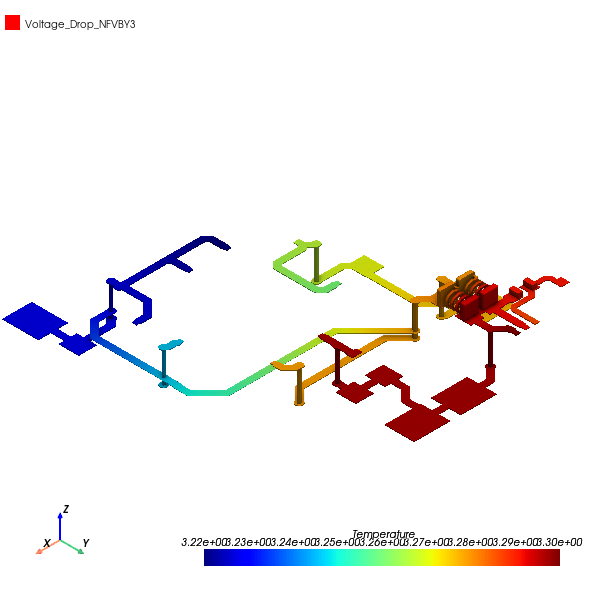

In [19]:
plot1 = q3d.post.create_fieldplot_surface(
    q3d.modeler.get_objects_by_material("copper"),
    quantity=voltage_drop,
    intrinsics={"Freq": "1GHz"},
)

q3d.post.plot_field_from_fieldplot(
    plot1.name,
    project_path=temp_folder.name,
    mesh_plot=False,
    image_format="jpg",
    view="isometric",
    show=False,
    plot_cad_objs=False,
    log_scale=False,
)

## Compute voltage on source circles

Use PyAEDT advanced field calculator to compute the voltage on source circles and get the value
using the ``get_solution_data()`` method.

In [20]:
v_surface = {
    "name": "",
    "description": "Maximum value of voltage on a surface",
    "design_type": ["Q3D Extractor"],
    "fields_type": ["DC R/L Fields"],
    "primary_sweep": "Freq",
    "assignment": "",
    "assignment_type": ["Face", "Sheet"],
    "operations": [
        f"NameOfExpression({voltage_drop})",
        "EnterSurface('assignment')",
        "Operation('SurfaceValue')",
        "Operation('Maximum')",
    ],
    "report": ["Field_3D"],
}
for source_circle, source_bound in zip(sources_objs, sources_bounds):
    v_surface["name"] = "V{}".format(source_bound.name)
    q3d.post.fields_calculator.add_expression(v_surface, source_circle.name)

    data = q3d.post.get_solution_data(
        "V{}".format(source_bound.name),
        q3d.nominal_adaptive,
        variations={"Freq": "1GHz"},
        report_category="DC R/L Fields",
    )
    if data:
        print(data.data_real("V{}".format(source_bound.name)))

PyAEDT INFO: Solution Data Correctly Loaded.


[3.2604766841795274]
PyAEDT INFO: Solution Data Correctly Loaded.


[3.2604766841795274]


PyAEDT INFO: Solution Data Correctly Loaded.


[3.2604766841795274]


## Release AEDT

In [21]:
q3d.save_project()
q3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project HSD_q3d Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [22]:
temp_folder.cleanup()